In [36]:
from matplotlib import pyplot as plt

import numpy as np

from fit.matrices.const_mats import create_p2d_mat
from fit.matrices.top_mats import create_top_mats
from fit.mesh.mesh import Mesh
from fit.plot.plot_pot import plot_pot
from fit.solver.solve_poisson import solve_poisson

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
## Generate mesh
n = 50
nz = 5
xmesh = np.linspace(0, 1, n)
ymesh = np.linspace(0, 1, n)
zmesh = np.linspace(0, 1, nz)
msh = Mesh(xmesh, ymesh, zmesh)

In [38]:
## Set boundary conditions
V0 = 0

bc = np.full(msh.np, np.nan)
idx_bc_1 = []
idx_bc_2 = []

for i in range(int(n/2)):
    for k in range(nz):
        idx_bc_1.append(msh.idx(i, int(n/4), k))
        idx_bc_1.append(msh.idx(i+int(n/2), int(n/3), k))
        idx_bc_2.append(msh.idx(i, int(3*n/4), k))
        idx_bc_2.append(msh.idx(i+int(n/2), int(2*n/3), k))

bc[idx_bc_1] = 0
bc[idx_bc_2] = V0

In [39]:
## Current excitation
I0 = 1e7

# TODO: Update excitation
g,_,_ = create_top_mats(msh)
# i = np.zeros(3*msh.np)
# i[msh.idx(int(n/2), int(n/2), np.arange(nz)) + 2*msh.np] = I0
# q = -g.T @ i
idx = [msh.idx(0, int(n/2 + i), np.arange(nz)) for i in np.linspace(-10, 10)]
q = np.zeros(msh.np)
q[idx] = I0

In [40]:
## Solve system
eps = 8.854e-12
sig = 58e6
phi = solve_poisson(msh, q, sig, bc)

In [41]:
def plot_z_surf(arr: np.ndarray, z: int, cmap='viridis', xlabel='$x$ (m)', ylabel='$y$ (m)', title=''):
    """Plots the given 3D ``arr`` on a ``z``-surface."""
    
    arr_surf = np.reshape(arr, (msh.nz, msh.ny, msh.nx))
    plt.rcParams['text.usetex'] = True
    plt.imshow(arr_surf[z,:,:], cmap=cmap)
    plt.xlim([0, n])
    plt.ylim([0, n])
    plt.xticks(ticks=np.linspace(0, n, 5), labels=np.linspace(0, 1, 5))
    plt.yticks(ticks=np.linspace(0, n, 5), labels=np.linspace(0, 1, 5))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.colorbar()
    plt.show()

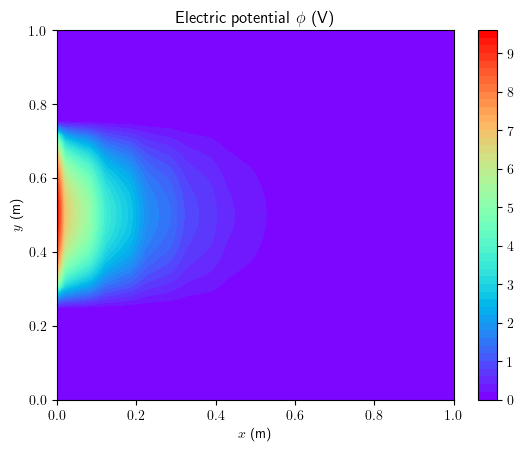

In [68]:
## Plot phi
plot_pot(msh, phi, nz=2, levels=n, cmap='rainbow', title='Electric potential $\phi$ (V)')

In [52]:
def plot_field(u: np.ndarray, z: int):
    x, y = np.meshgrid(xmesh, ymesh)
    ux = u[0:msh.np]
    ux = np.reshape(ux, (msh.nz, msh.ny, msh.nx))
    ux = ux[z,:,:]
    uy = u[msh.np:2*msh.np]
    uy = np.reshape(uy, (msh.nz, msh.ny, msh.nx))
    uy = uy[z,:,:]

    # Normalize
    magnitude = np.sqrt(ux**2 + uy**2)
    ux = ux / magnitude
    uy = uy / magnitude

    plt.quiver(x, y, ux, uy)

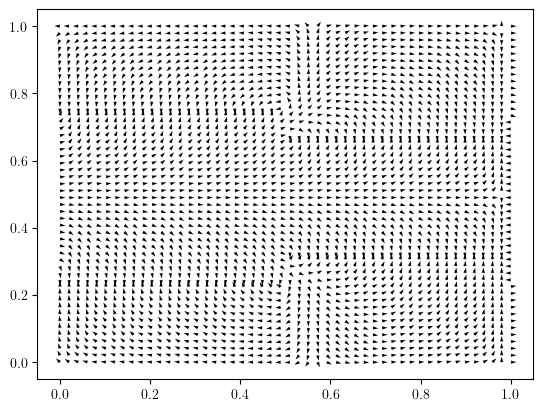

In [44]:
# Electrical field
e = -g @ phi
plot_field(e, 2)

In [45]:
## Power calculation
m_sig = create_p2d_mat(msh, sig)    # Conductivity matrix
u = -g@phi                          # Voltage vector
i = m_sig@g@phi                     # Current vector
pe = u*i                            # Power on edge vector
pv = 0.5*np.abs(g.T) @ pe           # Power on dual volume vector

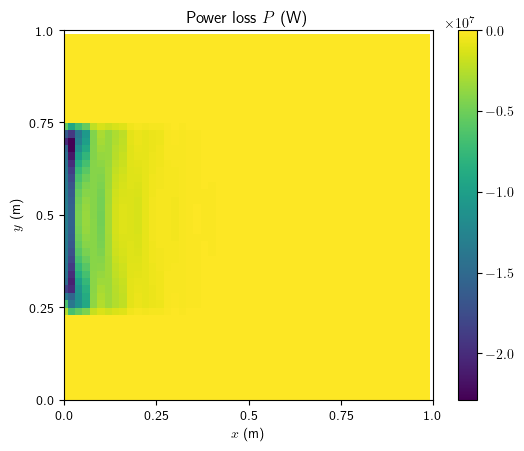

In [46]:
## Plot power
plot_z_surf(pv, z=2, title='Power loss $P$ (W)')

In [47]:
## Solve thermal system
cond = 401
theta = solve_poisson(msh, pv, cond, bc)

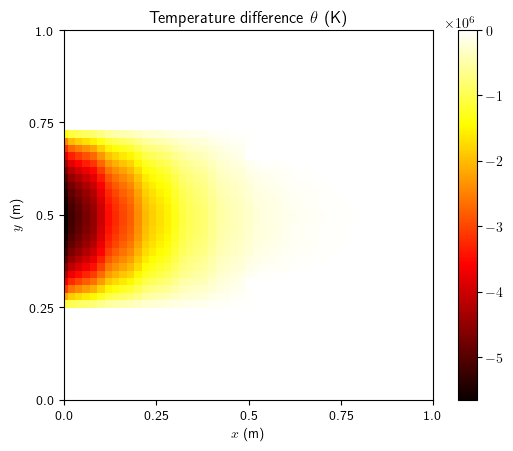

In [48]:
## Plot theta
plot_z_surf(theta, z=2, cmap='hot', title=r'Temperature difference $\theta$ (K)')